In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

In [32]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df = pd.read_csv('/content/AEV Historical Data_Cleaned.csv', usecols=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df.asfreq('B')

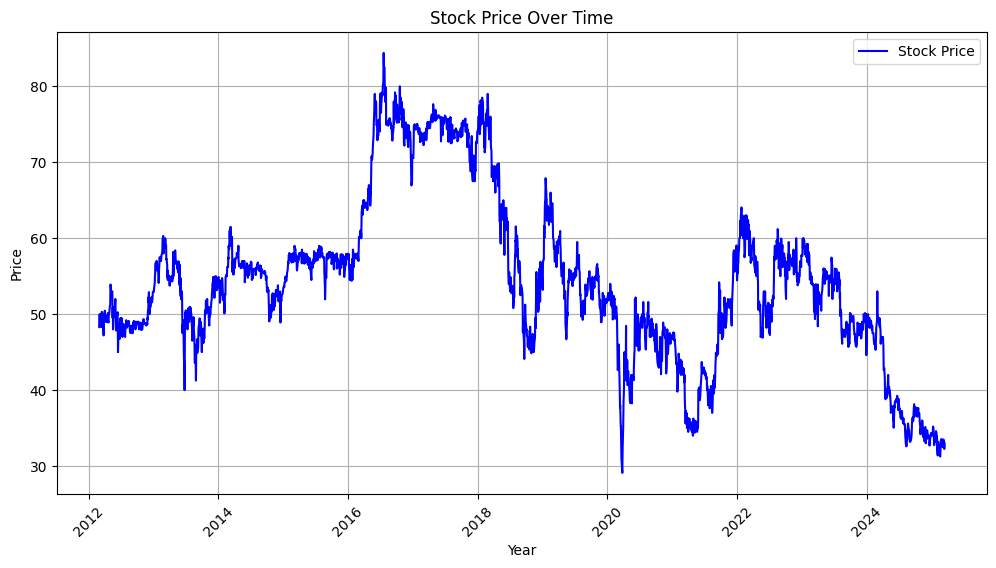

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label="Stock Price", color='blue')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Stock Price Over Time")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid()
plt.show()

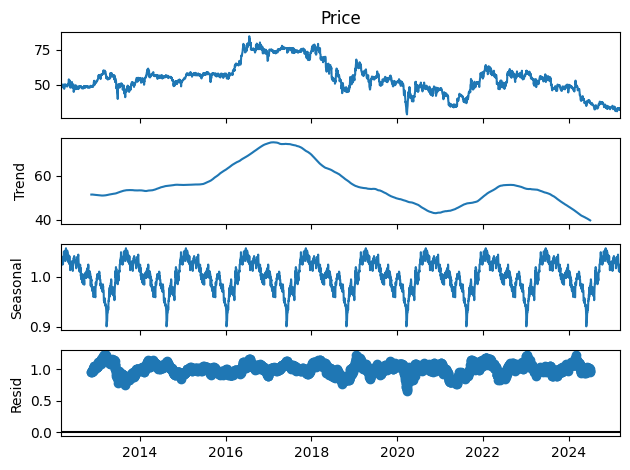

In [34]:
results = seasonal_decompose(df['Price'], model='multiplicative', period=365)
results.plot()
plt.show()

In [35]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

In [36]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [37]:
scaled_train = np.array(scaled_train).reshape(-1, 1)
scaled_val = np.array(scaled_val).reshape(-1, 1)
scaled_test = np.array(scaled_test).reshape(-1, 1)

In [38]:
n_input = 90
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)

In [39]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 90, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
checkpoint = ModelCheckpoint("AEV_model.h5", save_best_only=True, monitor='val_loss', mode='min')

In [41]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping, checkpoint])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2631/2631 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0072

2631/2631 ━━━━━━━━━━━━━━━━━━━━ 247s 92ms/step - loss: 0.0072 - val_loss: 0.0013
Epoch 2/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0016

2631/2631 ━━━━━━━━━━━━━━━━━━━━ 262s 92ms/step - loss: 0.0016 - val_loss: 7.6387e-04
Epoch 3/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0017

2631/2631 ━━━━━━━━━━━━━━━━━━━━ 243s 92ms/step - loss: 0.0017 - val_loss: 4.6485e-04
Epoch 4/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 246s 93ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 5/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0013

2631/2631 ━━━━━━━━━━━━━━━━━━━━ 252s 96ms/step - loss: 0.0013 - val_loss: 4.5790e-04
Epoch 6/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0012

2631/2631 ━━━━━━━━━━━━━━━━━━━━ 251s 95ms/step - loss: 0.0012 - val_loss: 3.8438e-04
Epoch 7/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 251s 95ms/step - loss: 0.0011 - val_loss: 7.6701e-04
Epoch 8/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 248s 94ms/step - loss: 0.0012 - val_loss: 8.3226e-04
Epoch 9/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 249s 94ms/step - loss: 0.0011 - val_loss: 5.3699e-04
Epoch 10/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0010

2631/2631 ━━━━━━━━━━━━━━━━━━━━ 248s 94ms/step - loss: 0.0010 - val_loss: 3.5973e-04
Epoch 11/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 249s 95ms/step - loss: 9.7790e-04 - val_loss: 4.3538e-04
Epoch 12/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 255s 97ms/step - loss: 8.5925e-04 - val_loss: 3.9182e-04
Epoch 13/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 251s 95ms/step - loss: 9.1905e-04 - val_loss: 4.2222e-04
Epoch 14/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 250s 95ms/step - loss: 9.6870e-04 - val_loss: 3.6627e-04
Epoch 15/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 8.5442e-04

2631/2631 ━━━━━━━━━━━━━━━━━━━━ 253s 96ms/step - loss: 8.5444e-04 - val_loss: 3.5833e-04
Epoch 16/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 250s 95ms/step - loss: 8.8638e-04 - val_loss: 4.0358e-04
Epoch 17/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 252s 96ms/step - loss: 9.3001e-04 - val_loss: 4.0024e-04
Epoch 18/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 253s 96ms/step - loss: 8.6812e-04 - val_loss: 4.7746e-04
Epoch 19/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 251s 96ms/step - loss: 8.4906e-04 - val_loss: 3.6344e-04
Epoch 20/30
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 256s 97ms/step - loss: 8.6189e-04 - val_loss: 3.7238e-04


In [42]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model.save("AEV_Model.h5")

In [43]:
full_scaled = scaler.transform(df)
full_scaled = np.array(full_scaled).reshape(-1, 1)
first_eval_batch = full_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

future_steps = 7
future_predictions = []

for i in range(future_steps):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [44]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [45]:
actual_recent = df.tail(23)

In [46]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_steps, freq='B')

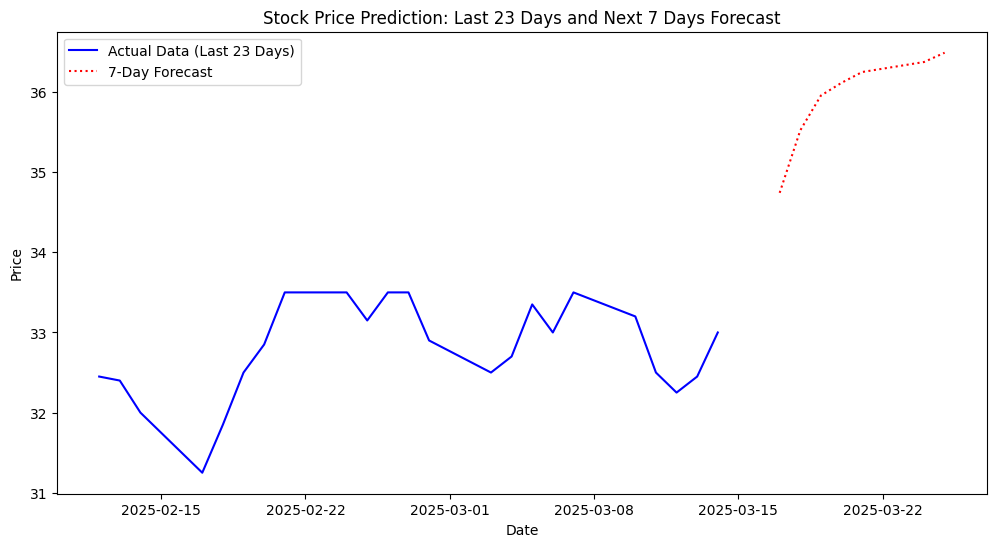

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(actual_recent.index, actual_recent['Price'], label='Actual Data (Last 23 Days)', color='blue')
plt.plot(future_dates, future_predictions, linestyle='dotted', color='red', label='7-Day Forecast')
plt.legend()
plt.title("Stock Price Prediction: Last 23 Days and Next 7 Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [48]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions.flatten()
})

In [49]:
forecast_df.to_csv('AEV_predictions.csv', index=False)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("Future predictions saved to 'future_predictions.csv'.")

Future predictions saved to 'future_predictions.csv'.
